# 1. Import the Lib

In [1]:
# Basic lib
import numpy as np
import pandas as pd

# Graph and Chart lib
import matplotlib.pyplot as pylt
import seaborn as sns
import pylab

# sesnality chart
import statsmodels.api as sm
from pylab import rcParams

# stats lib
import scipy.stats as stats

# text minning lib
import re

# feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble, linear_model, neighbors, metrics, tree
import xgboost
import pickle

#Performing RFE 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# f-regrresion
from sklearn.feature_selection import f_regression

# itration
import itertools

# linear regression
import statsmodels.formula.api as smf

# import the packages for vif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# validation lib
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

In [2]:
import warnings
warnings.filterwarnings("ignore")
pylt.style.use('fivethirtyeight')

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

## 2. Importing the data

In [3]:
# importing the data files
features = pd.read_csv('C:/my_computer/data_file/features.csv')
stores   = pd.read_csv('C:/my_computer/data_file/stores.csv')
train    = pd.read_csv('C:/my_computer/data_file/train.csv')
test     = pd.read_csv('C:/my_computer/data_file/test.csv')

In [4]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
Store           8190 non-null int64
Date            8190 non-null object
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
MarkDown1       4032 non-null float64
MarkDown2       2921 non-null float64
MarkDown3       3613 non-null float64
MarkDown4       3464 non-null float64
MarkDown5       4050 non-null float64
CPI             7605 non-null float64
Unemployment    7605 non-null float64
IsHoliday       8190 non-null bool
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


# 4. Data Analysis

### we have missing value in features only, so we first treat the missing values and then join the dataframes

In [6]:
# Treating Missing values
def missing_values(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
         x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode()[0])
    return x

features = features.apply(missing_values)

In [7]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
Store           8190 non-null int64
Date            8190 non-null object
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
MarkDown1       8190 non-null float64
MarkDown2       8190 non-null float64
MarkDown3       8190 non-null float64
MarkDown4       8190 non-null float64
MarkDown5       8190 non-null float64
CPI             8190 non-null float64
Unemployment    8190 non-null float64
IsHoliday       8190 non-null bool
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


### 4.2. DATA prepration

In [8]:
# Joining the Dataframes
combine = pd.merge(left=features, right=stores,how='left', on='Store' )

# combine train data
data_train = pd.merge(left=train, right=combine, how='left', on=['Date','Store','IsHoliday'])

# combine test data
data_test = pd.merge(left=test, right=combine, how='left', on=['Date','Store','IsHoliday'])

In [9]:
# changing date to datatime format
data_train['Date'] = pd.to_datetime(data_train.Date, format='%Y-%m-%d')
data_test['Date'] = pd.to_datetime(data_test.Date, format='%Y-%m-%d')
combine['Date'] = pd.to_datetime(combine.Date, format='%Y-%m-%d')

In [10]:
# drived varibales for train data
data_train['Year'] = data_train['Date'].dt.year
data_train['Month'] = data_train['Date'].dt.month
data_train['Week'] = data_train['Date'].dt.week
data_train['Qtr']  = data_train['Date'].dt.quarter

# drived varibales for test data
data_test['Year'] = data_test['Date'].dt.year
data_test['Month'] = data_test['Date'].dt.month
data_test['Week'] = data_test['Date'].dt.week
data_test['Qtr']  = data_test['Date'].dt.quarter

In [11]:
# seting date as index
data_train.set_index(data_train.Date, inplace=True)
data_test.set_index(data_test.Date, inplace=True)

In [12]:
# numercial and catogorical split of train data
data_train_num = data_train.loc[:,['Weekly_Sales','Size','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3',
                                'MarkDown4','MarkDown5','CPI','Unemployment']]

data_train_cat = data_train.loc[:,['Store','Dept','Type','IsHoliday','Year','Month', 'Week','Qtr']]

# numercial and catogorical split of test data
data_test_num = data_test.loc[:,['Size','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3',
                                'MarkDown4','MarkDown5','CPI','Unemployment']]

data_test_cat = data_test.loc[:,['Store','Dept','Type','IsHoliday','Year','Month', 'Week','Qtr']]

### 4.2. Summary details

In [13]:
#Numerical data Analysis :
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(),
                      x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),
                      x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75),
                      x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

data_train_num.apply(var_summary).T

N  NMISS           SUM           MEAN         MEDIAN  \
Weekly_Sales  421570.0    0.0  6.737219e+09   15981.258123    7612.030000   
Size          421570.0    0.0  5.764039e+10  136727.915739  140167.000000   
Temperature   421570.0    0.0  2.533217e+07      60.090059      62.090000   
Fuel_Price    421570.0    0.0  1.416908e+06       3.361027       3.452000   
MarkDown1     421570.0    0.0  2.996890e+09    7108.878720    7032.371786   
MarkDown2     421570.0    0.0  1.421155e+09    3371.101392    3384.176594   
MarkDown3     421570.0    0.0  6.980433e+08    1655.818147    1760.100180   
MarkDown4     421570.0    0.0  1.400381e+09    3321.824071    3292.935886   
MarkDown5     421570.0    0.0  1.817244e+09    4310.656911    4132.216422   
CPI           421570.0    0.0  7.217360e+07     171.201947     182.318780   
Unemployment  421570.0    0.0  3.355819e+06       7.960289       7.866000   

                       STD           VAR        MIN            P1  \
Weekly_Sales  22711.183519  5.157979e+08  -4988.940      5.000000   
Size          60980.583328  3.718632e+09  34875.000  34875.000000   
Temperature      18.447931  3.403262e+02     -2.060     18.300000   
Fuel_Price        0.458515  2.102356e-01      2.472      2.565000   
MarkDown1      4957.982138  2.458159e+07      0.270     58.340000   
MarkDown2      4867.542898  2.369297e+07   -265.760      1.500000   
MarkDown3      5489.657329  3.013634e+07    -29.100      0.350000   
MarkDown4      3560.601988  1.267789e+07      0.220     14.330000   
MarkDown5      3581.733359  1.282881e+07    135.160    548.020000   
CPI              39.159276  1.533449e+03    126.064    126.111903   
Unemployment      1.863296  3.471872e+00      3.879      4.156000   

                        P5           P10           P25            P50  \
Weekly_Sales     59.974500    291.097000   2079.650000    7612.030000   
Size          39690.000000  39910.000000  93638.000000  140167.000000   
Temperature      27.310000     33.980000     46.680000      62.090000   
Fuel_Price        2.653000      2.720000      2.933000       3.452000   
MarkDown1       709.320000   2565.800000   7032.371786    7032.371786   
MarkDown2        22.800000     96.940000   3384.176594    3384.176594   
MarkDown3         2.700000      7.170000    115.390000    1760.100180   
MarkDown4       273.530000    696.470000   3292.935886    3292.935886   
MarkDown5      1288.810000   2049.020000   4132.216422    4132.216422   
CPI             126.496258    128.823806    132.022667     182.318780   
Unemployment      5.326000      5.965000      6.891000       7.866000   

                        P75            P90            P95            P99  \
Weekly_Sales   20205.852500   42845.673000   61201.951000  106479.586000   
Size          202505.000000  204184.000000  206302.000000  219622.000000   
Temperature       74.280000      83.580000      87.270000      92.810000   
Fuel_Price         3.738000       3.917000       4.029000       4.202000   
MarkDown1       7032.371786    8624.560000   12407.710000   28177.290000   
MarkDown2       3384.176594    3384.176594    3789.560000   21813.160000   
MarkDown3       1760.100180    1760.100180    1760.100180    2083.280000   
MarkDown4       3292.935886    3292.935886    5163.630000   16822.460000   
MarkDown5       4132.216422    5284.630000    7456.150000   15590.530000   
CPI              212.416993     219.444244     221.941558     225.473509   
Unemployment       8.572000       9.816000      12.187000      14.180000   

                        MAX  
Weekly_Sales  693099.360000  
Size          219622.000000  
Temperature      100.140000  
Fuel_Price         4.468000  
MarkDown1      88646.760000  
MarkDown2     104519.540000  
MarkDown3     141630.610000  
MarkDown4      67474.850000  
MarkDown5     108519.280000  
CPI              227.232807  
Unemployment      14.313000

In [14]:
data_test_num.apply(var_summary).T

N  NMISS           SUM           MEAN         MEDIAN  \
Size          115064.0    0.0  1.570597e+10  136497.688921  140167.000000   
Temperature   115064.0    0.0  6.206760e+06      53.941804      54.470000   
Fuel_Price    115064.0    0.0  4.121070e+05       3.581546       3.606000   
MarkDown1     115064.0    0.0  8.846541e+08    7688.365870    4842.660000   
MarkDown2     115064.0    0.0  4.196391e+08    3647.005603    1568.710000   
MarkDown3     115064.0    0.0  2.701891e+08    2348.163287      94.925000   
MarkDown4     115064.0    0.0  3.853644e+08    3349.130897    1239.780000   
MarkDown5     115064.0    0.0  4.513594e+08    3922.681189    2390.430000   
CPI           115064.0    0.0  2.019013e+07     175.468703     172.460809   
Unemployment  115064.0    0.0  8.269065e+05       7.186492       7.826821   

                       STD           VAR           MIN            P1  \
Size          61106.926438  3.734056e+09  34875.000000  34875.000000   
Temperature      18.724153  3.505939e+02     -7.290000     11.440000   
Fuel_Price        0.239442  5.733244e-02      2.872000      2.957000   
MarkDown1     10691.857424  1.143158e+08  -2781.450000     20.840000   
MarkDown2      7215.736146  5.206685e+07    -35.740000      0.030000   
MarkDown3     13167.993068  1.733960e+08   -179.260000      0.170000   
MarkDown4      7133.962607  5.089342e+07      0.220000      2.880000   
MarkDown5     19445.150745  3.781139e+08   -185.170000    269.300000   
CPI              33.780998  1.141156e+03    131.236226    131.279355   
Unemployment      1.370824  1.879158e+00      3.684000      3.879000   

                     P5           P10           P25            P50  \
Size          39690.000  39910.000000  93638.000000  140167.000000   
Temperature      23.980     29.970000     39.820000      54.470000   
Fuel_Price        3.161      3.227000      3.431000       3.606000   
MarkDown1       189.490    457.660000   1974.680000    4842.660000   
MarkDown2        11.110     57.960000    306.120000    1568.710000   
MarkDown3         1.200      3.710000     18.000000      94.925000   
MarkDown4        20.640     42.960000    200.480000    1239.780000   
MarkDown5       540.890    770.883000   1309.300000    2390.430000   
CPI             131.747    132.320071    138.900429     172.460809   
Unemployment      4.893      5.275000      6.228000       7.826821   

                        P75            P90            P95            P99  \
Size          202505.000000  204184.000000  206302.000000  219622.000000   
Temperature       67.350000      79.480000      83.820000      92.140000   
Fuel_Price         3.766000       3.866000       3.951000       4.079000   
MarkDown1       9427.410000   15325.040000   23140.880000   65757.570000   
MarkDown2       3384.176594    6665.520000   15810.180000   38836.380000   
MarkDown3        418.520000    1760.100180    1760.100180   82544.960000   
MarkDown4       3292.935886    7170.570000   12723.810000   43631.940000   
MarkDown5       4227.270000    6966.340000    9316.710000   18599.300000   
CPI              201.212230     224.635985     227.251326     228.642888   
Unemployment       7.826821       8.667000       8.951000      10.199000   

                        MAX  
Size          219622.000000  
Temperature      101.950000  
Fuel_Price         4.125000  
MarkDown1     103184.980000  
MarkDown2      71074.170000  
MarkDown3     149483.310000  
MarkDown4      65344.640000  
MarkDown5     771448.100000  
CPI              228.976456  
Unemployment      10.199000

### 4.3 Outlier tearment

In [15]:
# treating outliers
def outlier_clip(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

# implementing outlier function
data_train_num = data_train_num.apply(outlier_clip)

In [16]:
data_train_num.apply(var_summary).T

N  NMISS           SUM           MEAN         MEDIAN  \
Weekly_Sales  421570.0    0.0  6.599483e+09   15654.535929    7612.030000   
Size          421570.0    0.0  5.764039e+10  136727.915739  140167.000000   
Temperature   421570.0    0.0  2.533977e+07      60.108106      62.090000   
Fuel_Price    421570.0    0.0  1.416587e+06       3.360265       3.452000   
MarkDown1     421570.0    0.0  2.938654e+09    6970.736994    7032.371786   
MarkDown2     421570.0    0.0  1.330473e+09    3155.995685    3384.176594   
MarkDown3     421570.0    0.0  5.243956e+08    1243.911197    1760.100180   
MarkDown4     421570.0    0.0  1.337418e+09    3172.468492    3292.935886   
MarkDown5     421570.0    0.0  1.759170e+09    4172.900167    4132.216422   
CPI           421570.0    0.0  7.217089e+07     171.195504     182.318780   
Unemployment  421570.0    0.0  3.355685e+06       7.959971       7.866000   

                       STD           VAR           MIN            P1  \
Weekly_Sales  20781.670902  4.318778e+08      5.000000      5.000000   
Size          60980.583328  3.718632e+09  34875.000000  34875.000000   
Temperature      18.297286  3.347907e+02     18.300000     18.300000   
Fuel_Price        0.456205  2.081234e-01      2.565000      2.565000   
MarkDown1      3882.201994  1.507149e+07     58.340000     58.340000   
MarkDown2      2691.713792  7.245323e+06      1.500000      1.500000   
MarkDown3       781.513378  6.107632e+05      0.350000      0.350000   
MarkDown4      2198.393252  4.832933e+06     14.330000     14.330000   
MarkDown5      2008.458518  4.033906e+06    548.020000    548.020000   
CPI              39.149643  1.532695e+03    126.111903    126.111903   
Unemployment      1.859419  3.457438e+00      4.156000      4.156000   

                        P5           P10           P25            P50  \
Weekly_Sales     59.974500    291.097000   2079.650000    7612.030000   
Size          39690.000000  39910.000000  93638.000000  140167.000000   
Temperature      27.310000     33.980000     46.680000      62.090000   
Fuel_Price        2.653000      2.720000      2.933000       3.452000   
MarkDown1       709.320000   2565.800000   7032.371786    7032.371786   
MarkDown2        22.800000     96.940000   3384.176594    3384.176594   
MarkDown3         2.700000      7.170000    115.390000    1760.100180   
MarkDown4       273.530000    696.470000   3292.935886    3292.935886   
MarkDown5      1288.810000   2049.020000   4132.216422    4132.216422   
CPI             126.496258    128.823806    132.022667     182.318780   
Unemployment      5.326000      5.965000      6.891000       7.866000   

                        P75            P90            P95            P99  \
Weekly_Sales   20205.852500   42845.673000   61201.951000  106477.746460   
Size          202505.000000  204184.000000  206302.000000  219622.000000   
Temperature       74.280000      83.580000      87.270000      92.810000   
Fuel_Price         3.738000       3.917000       4.029000       4.202000   
MarkDown1       7032.371786    8624.560000   12407.710000   28177.290000   
MarkDown2       3384.176594    3384.176594    3789.560000   21813.160000   
MarkDown3       1760.100180    1760.100180    1760.100180    2083.280000   
MarkDown4       3292.935886    3292.935886    5163.630000   16822.460000   
MarkDown5       4132.216422    5284.630000    7456.150000   15590.530000   
CPI              212.416993     219.444244     221.941558     225.473509   
Unemployment       8.572000       9.816000      12.187000      14.180000   

                        MAX  
Weekly_Sales  106479.586000  
Size          219622.000000  
Temperature       92.810000  
Fuel_Price         4.202000  
MarkDown1      28177.290000  
MarkDown2      21813.160000  
MarkDown3       2083.280000  
MarkDown4      16822.460000  
MarkDown5      15590.530000  
CPI              225.473509  
Unemployment      14.180000

### 4.4. Multicorrelation

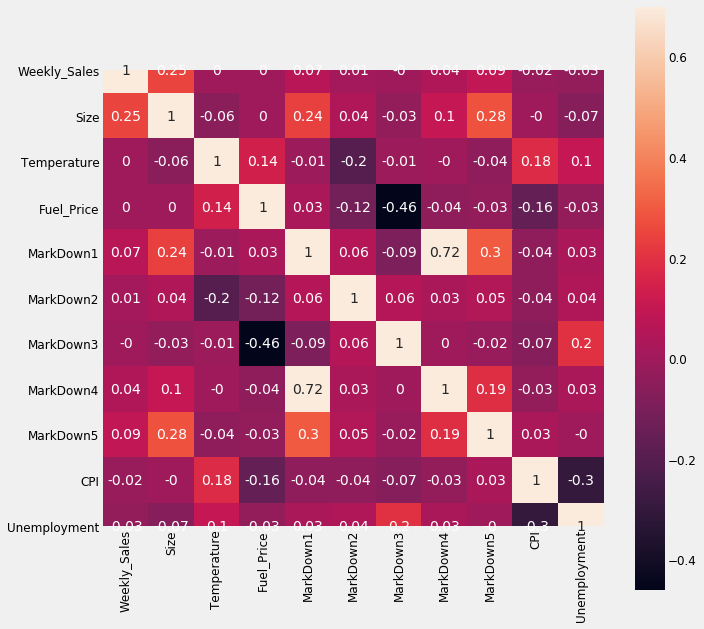

In [17]:
# checking correlation via heatmap
corr = np.round(data_train_num.corr(),2)
pylt.figure(figsize=(10,10))
sns.heatmap(data=corr, vmax=.7, square=True,annot=True)

In [18]:
#From above correlation plot
#----> Markdown1 and Markdown4 are positively highly correlated
#----> Markdown3 and Fuel_price are negatively highly correlated
#----> CPI and Unemployment are negativly correlated

In [19]:
# droping Markdown3 and Markdown4 to remove multicolinearity, as these also have high number of missing values
data_train_num.drop(['MarkDown3', 'MarkDown4'], axis=1, inplace=True)

In [20]:
# droping Markdown3 and Markdown4 to remove multicolinearity, as these also have high number of missing values
data_test_num.drop(['MarkDown3', 'MarkDown4'], axis=1, inplace=True)

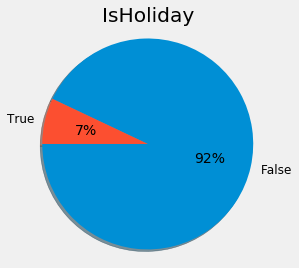

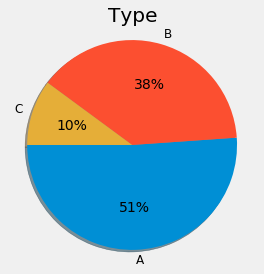

In [21]:
# checking distribution
for i in ['IsHoliday','Type']:
    labels =list(data_train_cat[str(i)].value_counts().index)
    size = data_train_cat[str(i)].value_counts()
    pylt.pie(size, labels=labels,autopct='%1.1d%%', shadow=True, startangle=180)
    pylt.axis('equal')
    pylt.title(str(i))
    pylt.plot()
    fig=pylt.gcf()
    fig.set_size_inches(4,4)
    pylt.show()

### 5. Sesnality

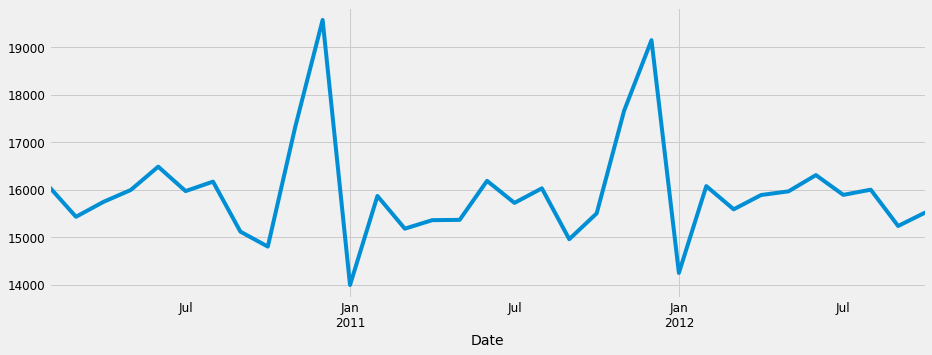

In [22]:
# sesnality char
data_train['Weekly_Sales'].resample('MS').mean().plot(figsize=(14,5))

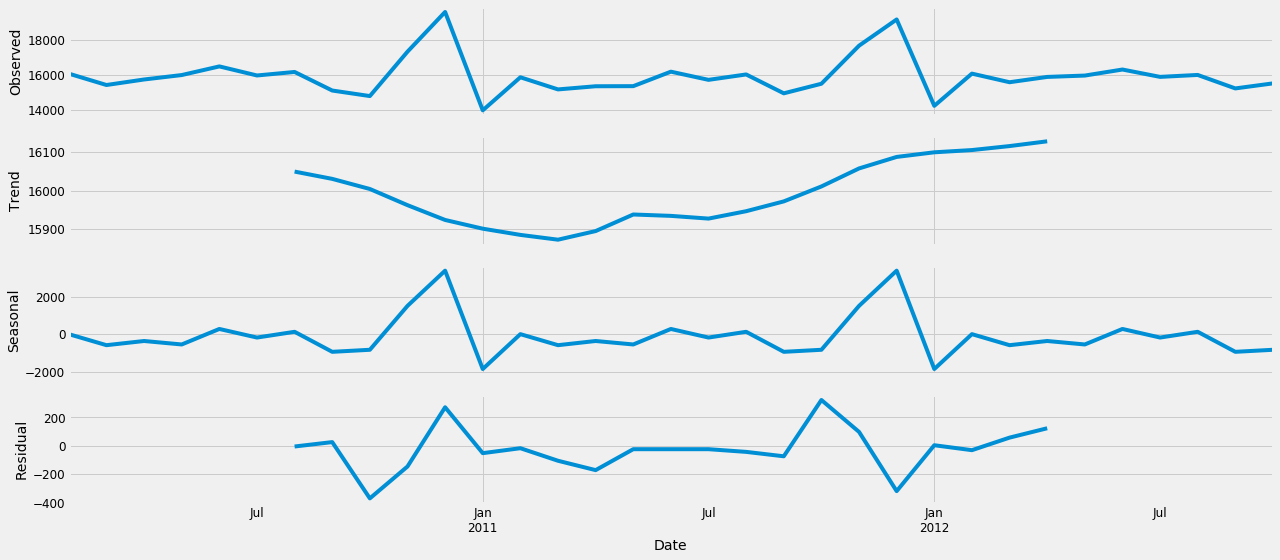

In [23]:
# all type of senality chart
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(data_train['Weekly_Sales'].resample('MS').mean(), model='additive')
fig = decomposition.plot()
pylt.show()

### 6. Creating dummy variables

In [24]:
# creating dummy
def create_dummy(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=True)
    df = pd.concat([df, col_dummies],axis=1)
    df.drop(colname,axis=1, inplace=True)
    return df

In [25]:
# implementing creatin of dummy def for train data
for c_features in data_train_cat.columns:
    data_train_cat[c_features] = data_train_cat[c_features].astype('category')
    data_train_cat = create_dummy(data_train_cat,c_features)
    
# implementing creatin of dummy def for test data
for c_features in data_test_cat.columns:
    data_test_cat[c_features] = data_test_cat[c_features].astype('category')
    data_test_cat = create_dummy(data_test_cat,c_features)

In [26]:
# final train data
data_train_final = pd.concat([data_train_num,data_train_cat],axis=1)

# final test data
data_test_final = pd.concat([data_test_num,data_test_cat],axis=1)

In [27]:
# droping not matching variables

data_train_final.drop(['Week_31','Week_32','Week_33','Week_34','Week_35',
                       'Week_36','Week_37','Week_38','Week_39','Week_40',
                       'Week_41','Week_42','Week_43','Year_2011','Year_2012','Month_10',
                       'Month_8','Month_9'], axis=1, inplace = True)
data_test_final.drop('Year_2013', axis=1,inplace=True)

## 7. Normality check

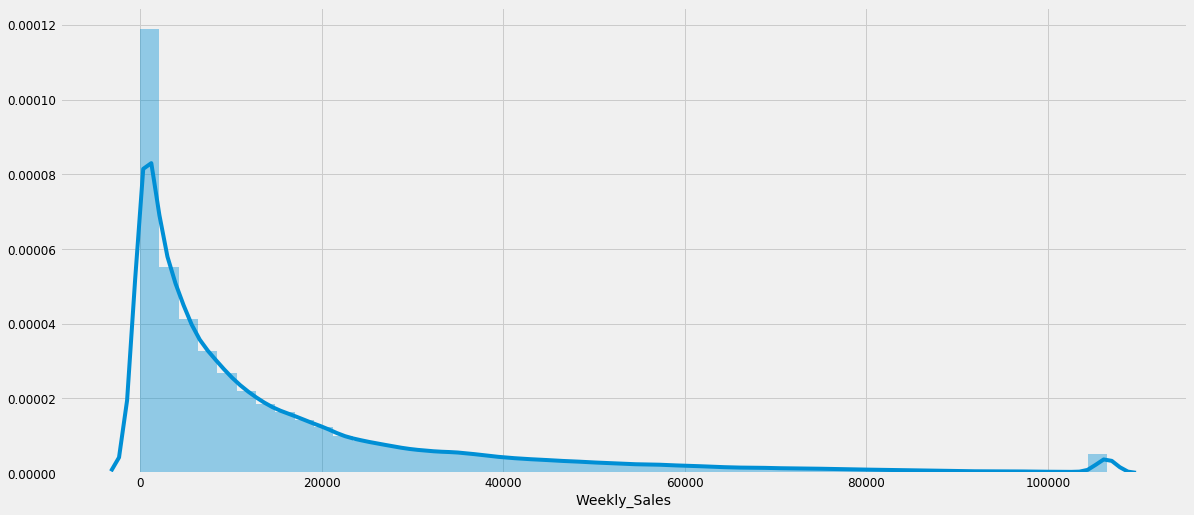

In [28]:
# Normality check
sns.distplot(data_train_final.Weekly_Sales)

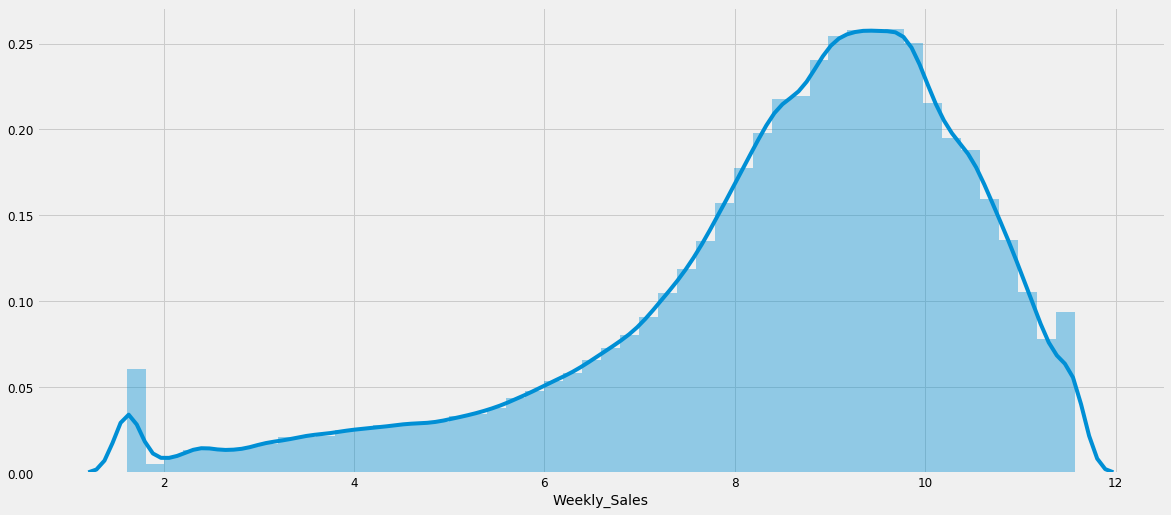

In [29]:
# normality check for log of weekly sales
sns.distplot(np.log(data_train_final.Weekly_Sales))

In [30]:
data_train_final['lnWeekly_Sales'] = np.log(data_train_final.Weekly_Sales)

# 8. Correlation matrix

In [31]:
# Linearity: correlation matrix (ranges from 1 to -1)
corrm = data_train_final.corr()
corrm.to_csv('data_train_final.csv')
corrm

Weekly_Sales      Size  Temperature  Fuel_Price  MarkDown1  \
Weekly_Sales        1.000000  0.252562     0.000733    0.001395   0.065079   
Size                0.252562  1.000000    -0.058823    0.004468   0.244487   
Temperature         0.000733 -0.058823     1.000000    0.142258  -0.009371   
Fuel_Price          0.001395  0.004468     0.142258    1.000000   0.030301   
MarkDown1           0.065079  0.244487    -0.009371    0.030301   1.000000   
...                      ...       ...          ...         ...        ...   
Week_52            -0.006908 -0.000090    -0.151807   -0.051571  -0.043720   
Qtr_2               0.000645  0.000458     0.175808    0.189508  -0.002218   
Qtr_3              -0.006740 -0.000068     0.562417    0.036298   0.047739   
Qtr_4               0.022957 -0.001204    -0.259448   -0.131825  -0.142380   
lnWeekly_Sales      0.675724  0.315027    -0.039230   -0.006057   0.094034   

                MarkDown2  MarkDown5       CPI  Unemployment   Store_2  ...  \
Weekly_Sales     0.007083   0.086458 -0.022697     -0.025362  0.074217  ...   
Size             0.043182   0.284428 -0.003307     -0.068099  0.169662  ...   
Temperature     -0.203653  -0.040474  0.184320      0.095296  0.068924  ...   
Fuel_Price      -0.120313  -0.029651 -0.162609     -0.034938 -0.048365  ...   
MarkDown1        0.061233   0.301032 -0.039537      0.034690  0.041680  ...   
...                   ...        ...       ...           ...       ...  ...   
Week_52          0.343893  -0.046616 -0.000867      0.008836  0.000078  ...   
Qtr_2           -0.035523  -0.048152 -0.001313      0.007758 -0.000227  ...   
Qtr_3           -0.137840  -0.007661  0.005717     -0.023357 -0.000215  ...   
Qtr_4            0.058280   0.064679  0.000548     -0.001495 -0.000031  ...   
lnWeekly_Sales   0.011990   0.103471 -0.015868     -0.043133  0.062567  ...   

                 Week_47   Week_48   Week_49   Week_50   Week_51   Week_52  \
Weekly_Sales    0.021788  0.004624  0.014523  0.022829  0.048863 -0.006908   
Size           -0.000078 -0.000422 -0.000292 -0.000642 -0.000109 -0.000090   
Temperature    -0.077645 -0.109049 -0.142320 -0.130912 -0.133057 -0.151807   
Fuel_Price     -0.047113 -0.056086 -0.049080 -0.049011 -0.052721 -0.051571   
MarkDown1      -0.097141 -0.034755 -0.029692 -0.055901 -0.090193 -0.043720   
...                  ...       ...       ...       ...       ...       ...   
Week_52        -0.014322 -0.014303 -0.014321 -0.014338 -0.014351  1.000000   
Qtr_2          -0.073243 -0.073143 -0.073236 -0.073324 -0.073392 -0.073161   
Qtr_3          -0.074429 -0.074328 -0.074423 -0.074512 -0.074581 -0.074347   
Qtr_4           0.226985  0.226676  0.226966  0.227236  0.227448  0.226734   
lnWeekly_Sales  0.014730  0.005581  0.012482  0.017645  0.029112 -0.004256   

                   Qtr_2     Qtr_3     Qtr_4  lnWeekly_Sales  
Weekly_Sales    0.000645 -0.006740  0.022957        0.675724  
Size            0.000458 -0.000068 -0.001204        0.315027  
Temperature     0.175808  0.562417 -0.259448       -0.039230  
Fuel_Price      0.189508  0.036298 -0.131825       -0.006057  
MarkDown1      -0.002218  0.047739 -0.142380        0.094034  
...                  ...       ...       ...             ...  
Week_52        -0.073161 -0.074347  0.226734       -0.004256  
Qtr_2           1.000000 -0.380208 -0.322676        0.000339  
Qtr_3          -0.380208  1.000000 -0.327905       -0.010718  
Qtr_4          -0.322676 -0.327905  1.000000        0.023672  
lnWeekly_Sales  0.000339 -0.010718  0.023672        1.000000  

[186 rows x 186 columns]

# 9. Feature selection

In [45]:
# freature selection for linear regression model usinf RFE and f-regressor
features = data_train_final[data_train_final.columns.difference(['Weekly_Sales', 'lnWeekly_Sales'])]
target = data_train_final['lnWeekly_Sales']

# define the model
lm_RFE = LinearRegression()

# creating the RFE model and select the 50 attributes
model_RFE = RFE(lm_RFE, n_features_to_select=50)
model_RFE = model_RFE.fit(features, target)

# capturing the important variables
RFE_features_columns = features.columns[model_RFE.get_support()]
RFE_features = features[RFE_features_columns]



In [46]:
F_values, p_values  = f_regression(RFE_features, target )

# itrate based on RFE selected features
f_reg_results = [(i, v, z) for i, v, z in itertools.zip_longest(RFE_features.columns, F_values,  ['%.3f' % p for p in p_values])]
f_reg_results=pd.DataFrame(f_reg_results, columns=['Variable','F_Value', 'P_Value'])

# features with there f_values and P_values as important features 
f_reg_results=pd.DataFrame(f_reg_results, columns=['Variable','F_Value', 'P_Value'])
f_reg_results = f_reg_results.sort_values(by=['P_Value'])

f_reg_results

Variable       F_Value P_Value
0   Month_11     50.331018   0.000
40   Week_47     91.488194   0.000
15    Type_C  24830.396480   0.000
14  Store_44   5650.123411   0.000
13  Store_43   2021.750264   0.000
12  Store_42   2531.149325   0.000
11  Store_38   5281.803018   0.000
9   Store_30   4584.884496   0.000
10  Store_37   2389.454446   0.000
42   Week_49     65.691792   0.000
44   Week_50    131.287714   0.000
45   Week_51    357.591859   0.000
1   Month_12    329.049507   0.000
41   Week_48     13.131463   0.000
20   Week_14     10.335404   0.001
47    Week_7     10.627109   0.001
36   Week_30      7.805913   0.005
23   Week_17      7.910408   0.005
48    Week_8      6.678250   0.010
28   Week_22      6.103417   0.013
3    Month_3      5.582821   0.018
46    Week_6      5.168249   0.023
49    Week_9      4.523619   0.033
7    Month_7      4.151563   0.042
16   Week_10      3.987519   0.046
35   Week_29      3.997272   0.046
37   Week_44      2.893770   0.089
6    Month_6      2.794556   0.095
38   Week_45      2.097216   0.148
26   Week_20      1.746893   0.186
34   Week_28      1.626161   0.202
33   Week_27      1.283751   0.257
39   Week_46      1.279967   0.258
5    Month_5      1.212580   0.271
29   Week_23      1.212716   0.271
22   Week_16      1.169548   0.279
2    Month_2      1.046589   0.306
19   Week_13      1.046276   0.306
43    Week_5      0.974099   0.324
18   Week_12      0.931477   0.334
25   Week_19      0.832963   0.361
21   Week_15      0.507249   0.476
32   Week_26      0.390477   0.532
31   Week_25      0.226155   0.634
30   Week_24      0.118024   0.731
4    Month_4      0.066234   0.797
8      Qtr_2      0.048388   0.826
17   Week_11      0.033087   0.856
27   Week_21      0.013909   0.906
24   Week_18      0.000202   0.989

In [47]:
#If p - values are less, then variables are siginificant in the regression equation
f_reg_results_new = f_reg_results[f_reg_results['P_Value'] <= '0.1']
f_reg_results_new

Variable       F_Value P_Value
0   Month_11     50.331018   0.000
40   Week_47     91.488194   0.000
15    Type_C  24830.396480   0.000
14  Store_44   5650.123411   0.000
13  Store_43   2021.750264   0.000
12  Store_42   2531.149325   0.000
11  Store_38   5281.803018   0.000
9   Store_30   4584.884496   0.000
10  Store_37   2389.454446   0.000
42   Week_49     65.691792   0.000
44   Week_50    131.287714   0.000
45   Week_51    357.591859   0.000
1   Month_12    329.049507   0.000
41   Week_48     13.131463   0.000
20   Week_14     10.335404   0.001
47    Week_7     10.627109   0.001
36   Week_30      7.805913   0.005
23   Week_17      7.910408   0.005
48    Week_8      6.678250   0.010
28   Week_22      6.103417   0.013
3    Month_3      5.582821   0.018
46    Week_6      5.168249   0.023
49    Week_9      4.523619   0.033
7    Month_7      4.151563   0.042
16   Week_10      3.987519   0.046
35   Week_29      3.997272   0.046
37   Week_44      2.893770   0.089
6    Month_6      2.794556   0.095

# 10. Liner regression  model

In [48]:
# data_train_final split in train and test
train_train, train_test = train_test_split(data_train_final, test_size=0.3, random_state=12345)

In [49]:
# modeling linear regression
feature_model = 'lnWeekly_Sales ~ '+'+'.join(f_reg_results_new.Variable)
print(feature_model)

# regression model
model_reg = smf.ols(feature_model, data=train_train).fit()

print(model_reg.summary())

lnWeekly_Sales ~ Month_11+Week_47+Type_C+Store_44+Store_43+Store_42+Store_38+Store_30+Store_37+Week_49+Week_50+Week_51+Month_12+Week_48+Week_14+Week_7+Week_30+Week_17+Week_8+Week_22+Month_3+Week_6+Week_9+Month_7+Week_10+Week_29+Week_44+Month_6
                            OLS Regression Results                            
Dep. Variable:         lnWeekly_Sales   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     670.3
Date:                Mon, 27 Jul 2020   Prob (F-statistic):               0.00
Time:                        09:50:52   Log-Likelihood:            -6.2087e+05
No. Observations:              295099   AIC:                         1.242e+06
Df Residuals:                  295070   BIC:                         1.242e+06
Df Model:                          28                                         
Covariance Type:            nonrobust        

In [50]:
# separate the Y and X variables
y, X = dmatrices(feature_model, train_train, return_type = 'dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif.sort_values(by='VIF Factor', ascending=False)

Features  VIF Factor
3      Type_C         inf
4    Store_44         inf
5    Store_43         inf
6    Store_42         inf
7    Store_38         inf
8    Store_30         inf
9    Store_37         inf
13   Month_12    4.748722
0   Intercept    2.158075
1    Month_11    1.989430
12    Week_51    1.967312
11    Week_50    1.966875
14    Week_48    1.963009
10    Week_49    1.956440
21    Month_3    1.851984
24    Month_7    1.767586
2     Week_47    1.477857
27    Week_44    1.473304
25    Week_10    1.397252
23     Week_9    1.394128
26    Week_29    1.353163
17    Week_30    1.348120
28    Month_6    1.347181
20    Week_22    1.269441
16     Week_7    1.021298
22     Week_6    1.021246
15    Week_14    1.021219
18    Week_17    1.020866
19     Week_8    1.020837

In [51]:
# removing the features having Vif > 5.0
feature_model2 = '''lnWeekly_Sales ~ Month_11+Week_47+Week_49+Week_50+Week_51+Month_12+Week_48+Week_14+Week_7+Week_30+
                    Week_17+Week_8+Week_22+Month_3+Week_6+Week_9+Month_7+Week_10+Week_29+Week_44+Month_6'''

In [52]:
# regression model
model_reg2 = smf.ols(feature_model2, data=train_train).fit()

print(model_reg2.summary())


# separate the Y and X variables
y, X = dmatrices(feature_model2, train_train, return_type = 'dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif.sort_values(by='VIF Factor', ascending=False)

                            OLS Regression Results                            
Dep. Variable:         lnWeekly_Sales   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     27.06
Date:                Mon, 27 Jul 2020   Prob (F-statistic):          9.71e-107
Time:                        09:51:25   Log-Likelihood:            -6.2968e+05
No. Observations:              295099   AIC:                         1.259e+06
Df Residuals:                  295077   BIC:                         1.260e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.4637      0.005   1572.951      0.0

Features  VIF Factor
6    Month_12    4.748680
0   Intercept    2.045066
1    Month_11    1.989394
5     Week_51    1.967305
4     Week_50    1.966852
7     Week_48    1.962997
3     Week_49    1.956421
14    Month_3    1.851976
17    Month_7    1.767570
2     Week_47    1.477847
20    Week_44    1.473292
18    Week_10    1.397370
16     Week_9    1.394122
19    Week_29    1.353156
10    Week_30    1.348113
21    Month_6    1.347163
13    Week_22    1.269431
9      Week_7    1.021294
15     Week_6    1.021239
8     Week_14    1.021210
11    Week_17    1.020862
12     Week_8    1.020830

In [53]:
#Tpredicting values in both training and testing data sets
train_train['lnpred'] =model_reg2.predict(train_train)
train_test['lnpred'] =model_reg2.predict(train_test)

#Checking Metrics for both training and testing data sets

print("MAPE for Training and testing data sets:")
MAPE_train = np.mean(np.abs(train_train.lnWeekly_Sales - train_train.lnpred)/train_train.lnWeekly_Sales)
print('Training   : ',MAPE_train)
MAPE_train = np.mean(np.abs(train_test.lnWeekly_Sales - train_test.lnpred)/train_test.lnWeekly_Sales)
print('Testing    : ',MAPE_train)
print("\nMSE for Training and testing data sets:")
#MSE for training and testing data sets                           
print('Training   : ',metrics.mean_squared_error(train_train.lnWeekly_Sales,train_train.lnpred)) 
print('Testing    : ',metrics.mean_squared_error(train_test.lnWeekly_Sales,train_test.lnpred))
print("\nRMSE for Training and testing data sets:")
#RMSE for training and testing data sets                           
print('Training   : ',np.sqrt(metrics.mean_squared_error(train_train.lnWeekly_Sales,train_train.lnpred)))
print('Testing    : ',np.sqrt(metrics.mean_squared_error(train_test.lnWeekly_Sales,train_test.lnpred)))
#Accuracy metrics (c. Correlation)
Corr_train = stats.stats.pearsonr(train_train.lnWeekly_Sales, train_train.lnpred)
Corr_test = stats.stats.pearsonr(train_test.lnWeekly_Sales, train_test.lnpred)
print('\nCorrelation for Training and testing data set:')
print('Training   : ', Corr_train)
print('Testing    : ', Corr_test)

MAPE for Training and testing data sets:
Training   :  0.2768603371717451
Testing    :  0.27663401812478045

MSE for Training and testing data sets:
Training   :  4.177518922939526
Testing    :  4.171333248896791

RMSE for Training and testing data sets:
Training   :  2.0438979727323785
Testing    :  2.042384206973994

Correlation for Training and testing data set:
Training   :  (0.04384113629767678, 1.7462379215103898e-125)
Testing    :  (0.04243020855401137, 1.7205237700252478e-51)


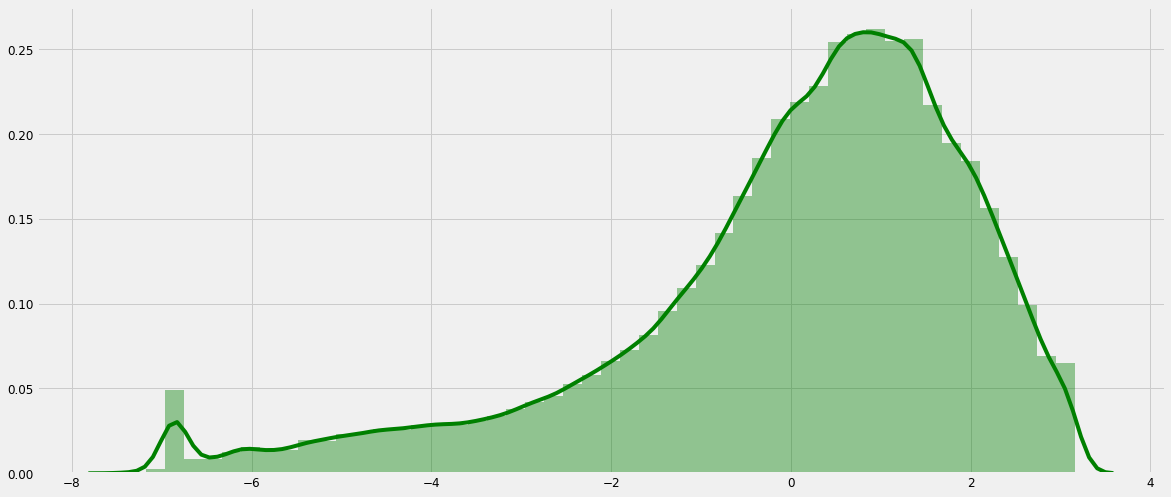

In [54]:
#Checking Errors distribution
sns.distplot(model_reg2.resid, color='green')

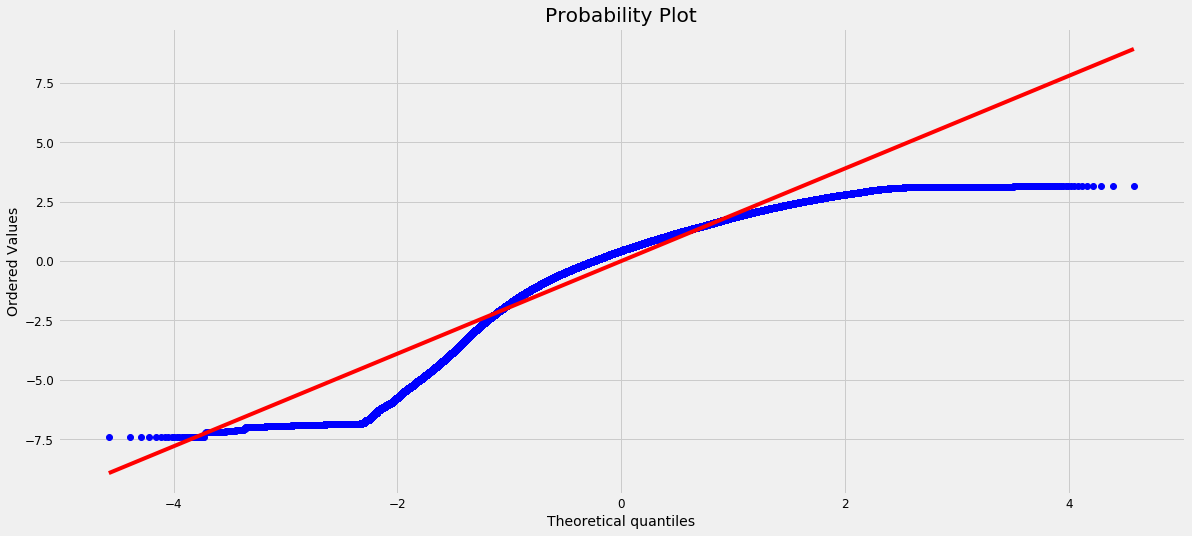

In [55]:
# probablity plot
stats.probplot(model_reg2.resid, dist = 'norm', plot = pylab)
pylab.show()

7.741813715970384e-14
(0.9990385151575131, 0.0)


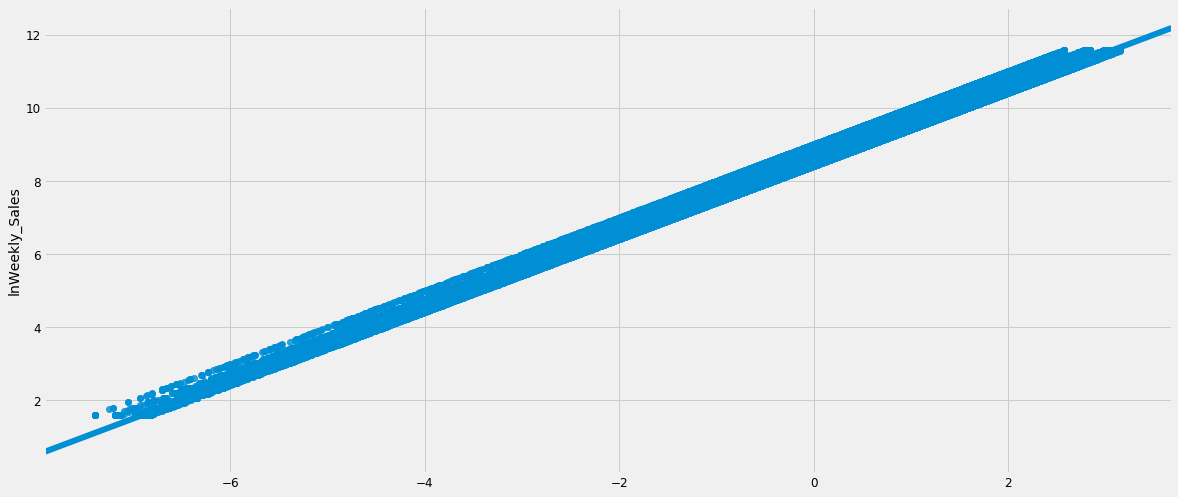

In [56]:
# assumption: mean of residuals/errors is zero
print(model_reg2.resid.mean())

# assumption: residuals/errors of the model should not be correlated with dependant (Y) variable
print(stats.stats.pearsonr(model_reg2.resid, train_train.lnWeekly_Sales))

sns.regplot(x=model_reg2.resid, y= train_train.lnWeekly_Sales)

In [57]:
#Decile analysis for validation of models - Business validation
train_train['Deciles']=pd.qcut(train_train['lnpred'],10, labels=False,duplicates='drop')
train_test['Deciles']=pd.qcut(train_test['lnpred'],10, labels=False,duplicates='drop')

# Decile Analysis for train data
Predicted_avg = train_train[['Deciles','lnpred']].groupby(train_train.Deciles).mean().sort_index(ascending=False)['lnpred']
Actual_avg = train_train[['Deciles','lnWeekly_Sales']].groupby(train_train.Deciles).mean().sort_index(ascending=False)['lnWeekly_Sales']

Decile_analysis_train = pd.concat([Predicted_avg, Actual_avg], axis=1)

Decile_analysis_train

lnpred  lnWeekly_Sales
Deciles                          
5        8.730099        8.730099
4        8.552937        8.552937
3        8.511735        8.511735
2        8.493774        8.493774
1        8.472649        8.472649
0        8.459710        8.459710

In [58]:
# Decile Analysis for train data
Predicted_avg = train_test[['Deciles','lnpred']].groupby(train_test.Deciles).mean().sort_index(ascending=False)['lnpred']
Actual_avg = train_test[['Deciles','lnWeekly_Sales']].groupby(train_test.Deciles).mean().sort_index(ascending=False)['lnWeekly_Sales']

Decile_analysis_test = pd.concat([Predicted_avg, Actual_avg], axis=1)

Decile_analysis_test

lnpred  lnWeekly_Sales
Deciles                          
5        8.730415        8.729132
4        8.552802        8.556225
3        8.511735        8.506880
2        8.493836        8.503521
1        8.472575        8.435128
0        8.459717        8.470809

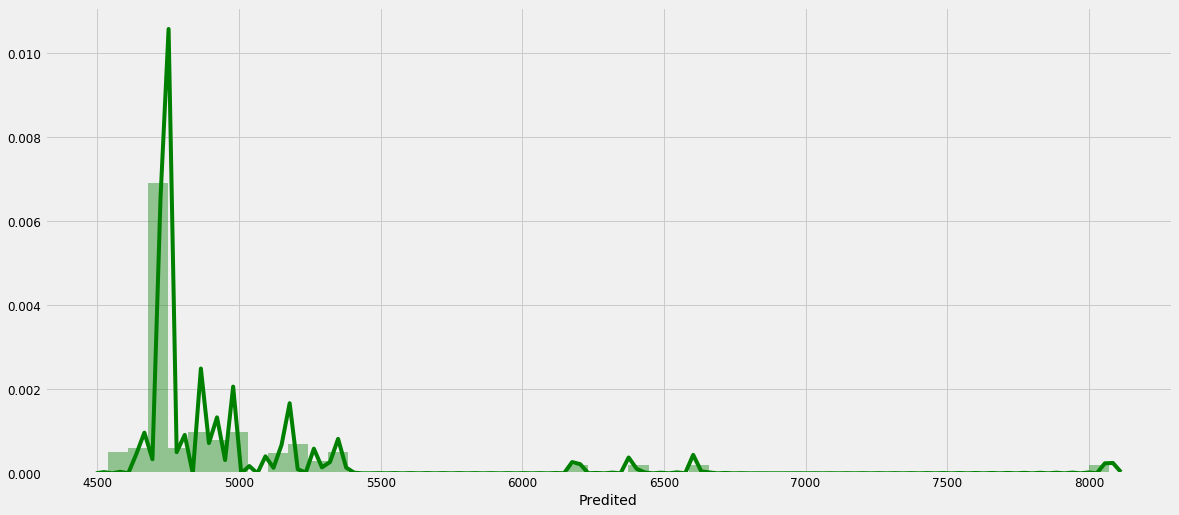

<Figure size 288x288 with 0 Axes>

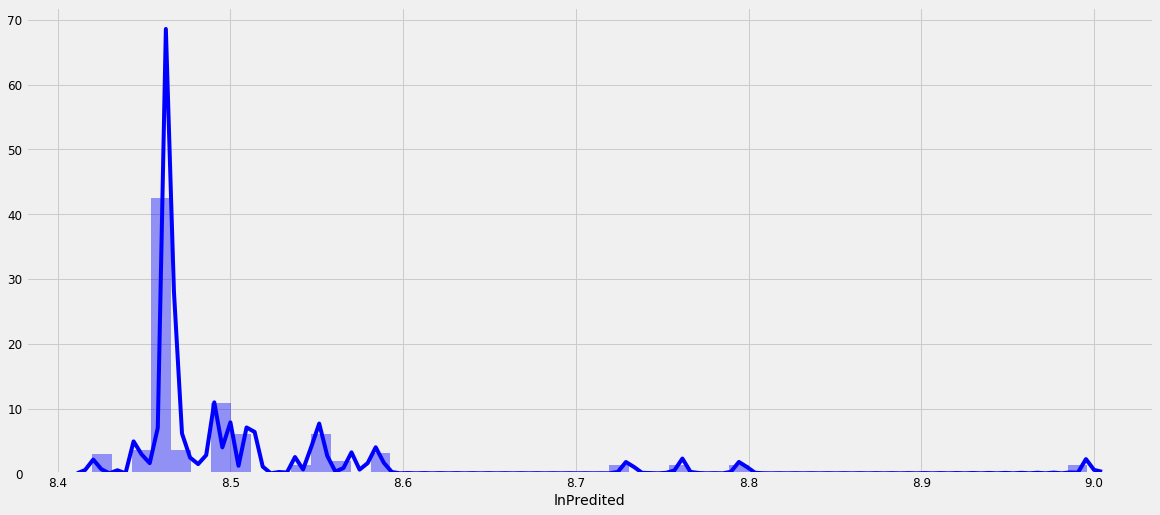

<Figure size 288x288 with 0 Axes>

In [59]:
data_train_final['Predited'] = np.exp(model_reg2.predict(data_train_final))
data_train_final['lnPredited'] = model_reg2.predict(data_train_final)

# Predicted normality check
sns.distplot(data_train_final.Predited,color = 'g')
pylt.figure(figsize=(4,4))
pylt.show()

sns.distplot(data_train_final.lnPredited,color = 'b')
pylt.figure(figsize=(4,4))
pylt.show()

In [60]:
# important features are :
print(str(f_reg_results_new.Variable))

0     Month_11
40     Week_47
15      Type_C
14    Store_44
13    Store_43
12    Store_42
11    Store_38
9     Store_30
10    Store_37
42     Week_49
44     Week_50
45     Week_51
1     Month_12
41     Week_48
20     Week_14
47      Week_7
36     Week_30
23     Week_17
48      Week_8
28     Week_22
3      Month_3
46      Week_6
49      Week_9
7      Month_7
16     Week_10
35     Week_29
37     Week_44
6      Month_6
Name: Variable, dtype: object


In [61]:
# predicting the test data for weekly sales
test_prediction = pd.DataFrame()

test_prediction['Predited_LR'] = np.exp(model_reg2.predict(data_test_final))
test_prediction['lnPredited_LR'] = model_reg2.predict(data_test_final)

In [62]:
test_prediction

Predited_LR  lnPredited_LR
Date                                  
2012-11-02  5102.475330       8.537481
2012-11-09  5178.163731       8.552206
2012-11-16  5178.163731       8.552206
2012-11-23  6382.380020       8.761296
2012-11-30  6084.433007       8.713489
...                 ...            ...
2013-06-28  4972.785752       8.511735
2013-07-05  4908.941737       8.498814
2013-07-12  4908.941737       8.498814
2013-07-19  4798.088744       8.475973
2013-07-26  4653.421919       8.445358

[115064 rows x 2 columns]

# 11. Decission Tree

In [63]:
from sklearn.tree import DecisionTreeRegressor

In [32]:
train_x, test_x, train_y, test_y= train_test_split(data_train_final[data_train_final.columns.difference(['Weekly_Sales', 'lnWeekly_Sales','Predited','lnPredited'])], data_train_final.lnWeekly_Sales,test_size=0.3, random_state=1234)

In [52]:
#decision tree with tuning parameters.
param_dt = {'max_depth': [5,6,7,8,10],'max_features':[8,12,15,20]}
model_tree = GridSearchCV(DecisionTreeRegressor(random_state=1234),
                          param_grid=param_dt,
                          cv=3,
                          verbose=True,
                          n_jobs=-1)
model_tree = model_tree.fit(train_x,train_y)

print('best combination:', model_tree.best_params_)
print('best score      :', model_tree.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   27.9s finished


best combination: {'max_depth': 10, 'max_features': 20}
best score      : 0.3104295676131864


In [64]:
model_tree = DecisionTreeRegressor(max_depth=10,max_features=20)
model_tree = model_tree.fit(train_x,train_y)

In [65]:
#Identifying Key variables and Printing top 20 variables.
feature_importances_tree = pd.DataFrame(model_tree.feature_importances_,
                                   index =train_x.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
ft_imp_tree = pd.DataFrame(feature_importances_tree)
ft_imp_tree.to_excel('ft_imp_tree.xlsx')
ft_imp_tree = ft_imp_tree.head(20)
lis_tree= ft_imp_tree.index
lis_tree

Index(['Type_C', 'Dept_45', 'Dept_59', 'Dept_92', 'Dept_38', 'Dept_28',
       'Dept_40', 'Dept_72', 'Dept_4', 'Dept_95', 'Dept_90', 'Dept_6',
       'Dept_93', 'Dept_9', 'Size', 'Store_13', 'Dept_54', 'Type_B',
       'Month_12', 'Store_33'],
      dtype='object')

In [66]:
# predicting the values
Dtree_train_pred = model_tree.predict(train_x)
Dtree_test_pred  = model_tree.predict(test_x)

#Metrics for both training and testing data 

#Mean Absolute Percentage Error 
print("MAPE values for training and testing data :")
MAPE_train = np.mean(np.abs(train_y - Dtree_train_pred)/train_y)
print('Train :',MAPE_train)
MAPE_test = np.mean(np.abs(test_y - Dtree_test_pred)/test_y)
print('Test  :',MAPE_test)

#Root Mean Squared error
print("\nRMSE values for training and testing data :")
RMSE_test = np.sqrt(mean_squared_error(train_y,Dtree_train_pred))
print('Train :',RMSE_test)
RMSE_test =np.sqrt(mean_squared_error(test_y,Dtree_test_pred))
print('Test  :',RMSE_test)

#MSE for training and testing data sets
print("\nMSE for Training and testing data sets:")
print('Training   : ',mean_squared_error(train_y,Dtree_train_pred)) 
print('Testing    : ',mean_squared_error(test_y,Dtree_test_pred))

#Accuracy metrics (c. Correlation)
print('\nCorrelation for Training and testing data set:')
Corr_train = stats.stats.pearsonr(train_y, Dtree_train_pred)
Corr_test = stats.stats.pearsonr(test_y, Dtree_test_pred)
print('Training   : ', Corr_train)
print('Testing    : ', Corr_test)

MAPE values for training and testing data :
Train : 0.22567983814336354
Test  : 0.22694389288466044

RMSE values for training and testing data :
Train : 1.7644885182356491
Test  : 1.7694214607482548

MSE for Training and testing data sets:
Training   :  3.113419730985437
Testing    :  3.1308523057564877

Correlation for Training and testing data set:
Training   :  (0.5057097086564802, 0.0)
Testing    :  (0.5017494592781742, 0.0)


In [67]:
from sklearn.tree import export_graphviz, export

In [68]:
import os     
os.environ["PATH"] += os.pathsep + 'C:/graphviz-2.38/release/bin'
#os.environ["PATH"] += os.pathsep + 'C:/ProgramData/Anaconda3/Library/bin/graphviz/'

# Exporting the tree output in the form opendocument
export_graphviz( model_tree,
              out_file = "model_tree.odt",
              feature_names = train_x.columns )

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.637838 to fit



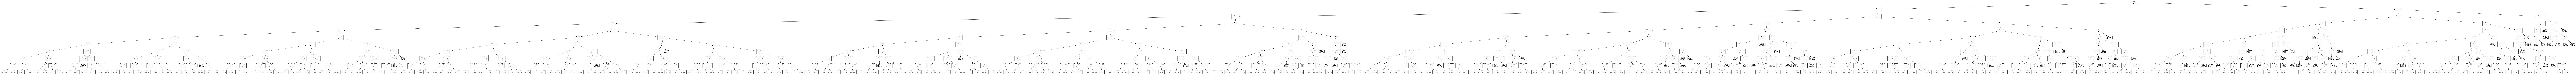

In [69]:
# Converting open document file to jpg imanage

import pydotplus as pdot
chd_tree_graph = pdot.graphviz.graph_from_dot_file( 'model_tree.odt' )

chd_tree_graph.write_jpg( 'model_tree.jpg' )

# Viewing the image in the notebook (display the image)
from IPython.display import Image
Image(filename='model_tree.jpg')

<Figure size 288x288 with 0 Axes>

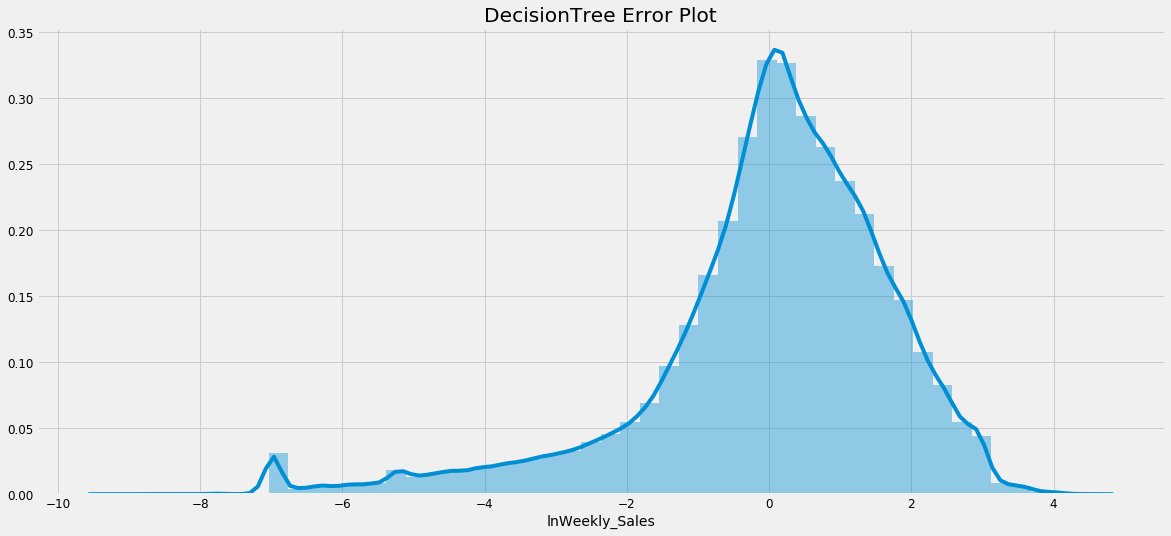

<Figure size 288x288 with 0 Axes>

In [70]:
sns.distplot(train_y-Dtree_train_pred)
pylt.title("DecisionTree Error Plot")
pylt.figure(figsize=(4,4))

In [71]:
# predicting the sale for test

test_prediction['Predited_Dtree'] = np.exp(model_tree.predict(data_test_final))
test_prediction['lnPredited_Dtree'] = model_tree.predict(data_test_final)

In [72]:
test_prediction

Predited_LR  lnPredited_LR  Predited_Dtree  lnPredited_Dtree
Date                                                                    
2012-11-02  5102.475330       8.537481     5420.201460          8.597888
2012-11-09  5178.163731       8.552206     5420.201460          8.597888
2012-11-16  5178.163731       8.552206     5420.201460          8.597888
2012-11-23  6382.380020       8.761296     5420.201460          8.597888
2012-11-30  6084.433007       8.713489     5420.201460          8.597888
...                 ...            ...             ...               ...
2013-06-28  4972.785752       8.511735       86.969974          4.465563
2013-07-05  4908.941737       8.498814       86.969974          4.465563
2013-07-12  4908.941737       8.498814       86.969974          4.465563
2013-07-19  4798.088744       8.475973       86.969974          4.465563
2013-07-26  4653.421919       8.445358       86.969974          4.465563

[115064 rows x 4 columns]

# ensemble

## `Bagging`

In [73]:
from sklearn.ensemble import BaggingRegressor

In [74]:
model_bagg = BaggingRegressor(n_estimators=120)

In [75]:
model_bagg = model_tree.fit(train_x,train_y)

In [76]:
#Identifying Key variables and Printing top 20 variables.
feature_importances_bagg = pd.DataFrame(model_bagg.feature_importances_,
                                   index =train_x.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
ft_imp_bagg = pd.DataFrame(feature_importances_bagg)
ft_imp_bagg.to_excel('ft_imp_bagg.xlsx')
ft_imp_bagg = ft_imp_bagg.head(20)
lis_bagg= ft_imp_bagg.index
print(lis_bagg)
print('---------------------------')


# predicting the values
Bagg_train_pred = model_bagg.predict(train_x)
Bagg_test_pred  = model_bagg.predict(test_x)

#Metrics for both training and testing data 

#Mean Absolute Percentage Error 
print("MAPE values for training and testing data :")
MAPE_train = np.mean(np.abs(train_y - Bagg_train_pred)/train_y)
print('Train :',MAPE_train)
MAPE_test = np.mean(np.abs(test_y - Bagg_test_pred)/test_y)
print('Test  :',MAPE_test)

#Root Mean Squared error
print("\nRMSE values for training and testing data :")
RMSE_test = np.sqrt(mean_squared_error(train_y,Bagg_train_pred))
print('Train :',RMSE_test)
RMSE_test =np.sqrt(mean_squared_error(test_y,Bagg_test_pred))
print('Test  :',RMSE_test)

#MSE for training and testing data sets
print("\nMSE for Training and testing data sets:")
print('Training   : ',mean_squared_error(train_y,Bagg_train_pred)) 
print('Testing    : ',mean_squared_error(test_y,Bagg_test_pred))

#Accuracy metrics (c. Correlation)
print('\nCorrelation for Training and testing data set:')
Corr_train = stats.stats.pearsonr(train_y, Bagg_train_pred)
Corr_test = stats.stats.pearsonr(test_y, Bagg_test_pred)
print('Training   : ', Corr_train)
print('Testing    : ', Corr_test)



Index(['Size', 'Dept_54', 'Dept_95', 'Dept_38', 'Dept_92', 'Dept_2', 'Dept_18',
       'Dept_72', 'Dept_90', 'Qtr_4', 'Store_37', 'Type_C', 'Dept_13',
       'Temperature', 'Dept_93', 'Store_30', 'MarkDown1', 'Qtr_2', 'Dept_52',
       'Unemployment'],
      dtype='object')
---------------------------
MAPE values for training and testing data :
Train : 0.22109976443574195
Test  : 0.22290204663045673

RMSE values for training and testing data :
Train : 1.7135954481332802
Test  : 1.7209449598187923

MSE for Training and testing data sets:
Training   :  2.9364093598630974
Testing    :  2.9616515547257047

Correlation for Training and testing data set:
Training   :  (0.5459453613142219, 0.0)
Testing    :  (0.5405455079752881, 0.0)


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.521046 to fit



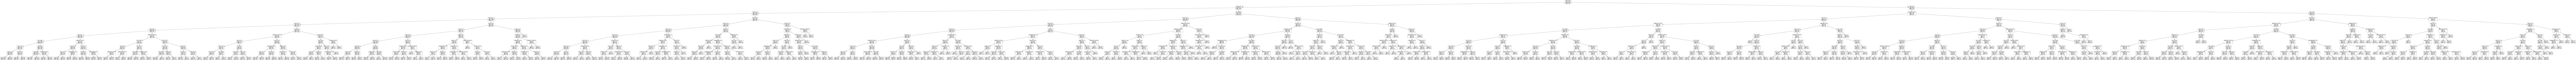

In [77]:
import os     
os.environ["PATH"] += os.pathsep + 'C:/graphviz-2.38/release/bin'
#os.environ["PATH"] += os.pathsep + 'C:/ProgramData/Anaconda3/Library/bin/graphviz/'

# Exporting the tree output in the form opendocument
export_graphviz( model_bagg,
              out_file = "model_bagg.odt",
              feature_names = train_x.columns)

# read ODT file
chd_tree_graph = pdot.graphviz.graph_from_dot_file( 'model_bagg.odt' )

# export the JPG tree image
chd_tree_graph.write_jpg( 'model_bagg.jpg' )

# show the JPG tree image
Image(filename='model_bagg.jpg')

<Figure size 288x288 with 0 Axes>

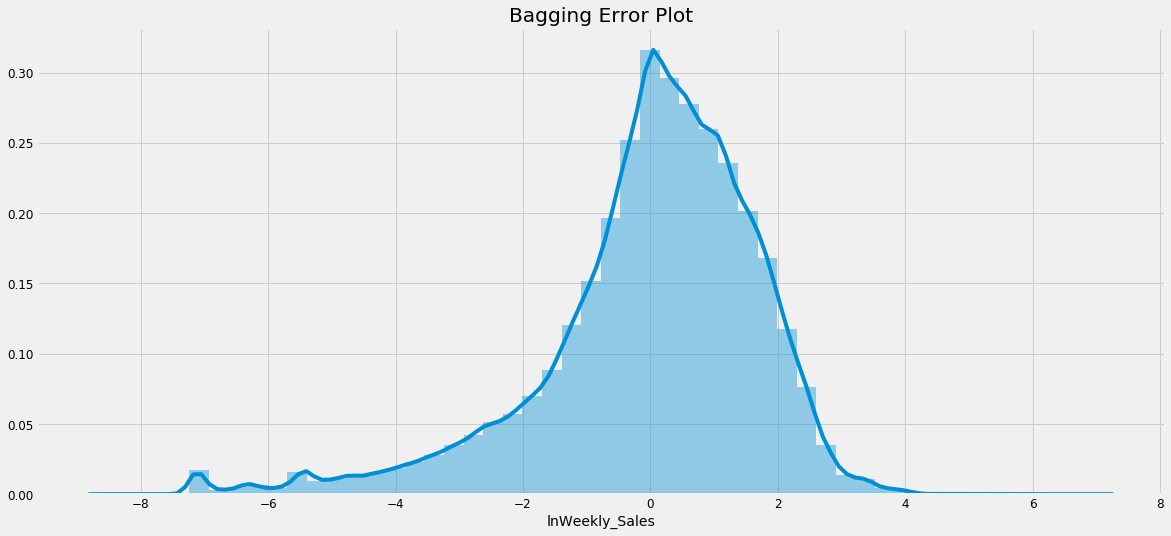

<Figure size 288x288 with 0 Axes>

In [78]:
sns.distplot(train_y-Bagg_train_pred)
pylt.title("Bagging Error Plot")
pylt.figure(figsize=(4,4))

In [79]:
# predicting the sale for test

test_prediction['Predited_Bagging'] = np.exp(model_bagg.predict(data_test_final))
test_prediction['lnPredited_Bagging'] = model_bagg.predict(data_test_final)

test_prediction

Predited_LR  lnPredited_LR  Predited_Dtree  lnPredited_Dtree  \
Date                                                                       
2012-11-02  5102.475330       8.537481     5420.201460          8.597888   
2012-11-09  5178.163731       8.552206     5420.201460          8.597888   
2012-11-16  5178.163731       8.552206     5420.201460          8.597888   
2012-11-23  6382.380020       8.761296     5420.201460          8.597888   
2012-11-30  6084.433007       8.713489     5420.201460          8.597888   
...                 ...            ...             ...               ...   
2013-06-28  4972.785752       8.511735       86.969974          4.465563   
2013-07-05  4908.941737       8.498814       86.969974          4.465563   
2013-07-12  4908.941737       8.498814       86.969974          4.465563   
2013-07-19  4798.088744       8.475973       86.969974          4.465563   
2013-07-26  4653.421919       8.445358       86.969974          4.465563   

            Predited_Bagging  lnPredited_Bagging  
Date                                              
2012-11-02      12277.534058            9.415526  
2012-11-09      12277.534058            9.415526  
2012-11-16      12277.534058            9.415526  
2012-11-23      12277.534058            9.415526  
2012-11-30      12277.534058            9.415526  
...                      ...                 ...  
2013-06-28      12277.534058            9.415526  
2013-07-05      12277.534058            9.415526  
2013-07-12      12277.534058            9.415526  
2013-07-19      12277.534058            9.415526  
2013-07-26      12277.534058            9.415526  

[115064 rows x 6 columns]

# ANN

In [37]:
#Importing required Module
from sklearn.neural_network import MLPRegressor

In [40]:
from sklearn.preprocessing import StandardScaler

#Standardising the data 
scaler = StandardScaler()
train_stdX = scaler.fit_transform(train_x)
test_stdX = scaler.fit_transform(test_x)

In [41]:
# fitting model with best params
model_ANN = MLPRegressor(activation='logistic', alpha=1.0)
model_ANN = model_ANN.fit(train_stdX,train_y)

In [44]:
#Metrics for both training and testing data 

#Mean Absolute Percentage Error 
print("MAPE values for training and testing data :")
MAPE_train = np.mean(np.abs(train_y - model_ANN.predict(train_stdX))/train_y)
print(MAPE_train)
MAPE_test = np.mean(np.abs(test_y- model_ANN.predict(test_stdX))/test_y)
print(MAPE_test)

#Root Mean Squared error
print("\nRMSE values for training and testing data :")
RMSE_test = np.sqrt(mean_squared_error(train_y,model_ANN.predict(train_stdX)))
print(RMSE_test)
RMSE_test =np.sqrt(mean_squared_error(test_y,model_ANN.predict(test_stdX)))
print(RMSE_test)

#MSE for training and testing data sets
print("\nMSE for Training and testing data sets:")
print('Training   : ',mean_squared_error(train_y,model_ANN.predict(train_stdX))) 
print('Testing    : ',mean_squared_error(test_y,model_ANN.predict(test_stdX)))

#Accuracy metrics (c. Correlation)
print('\nCorrelation for Training and testing data set:')
Corr_train = stats.stats.pearsonr(train_y, model_ANN.predict(train_stdX))
Corr_test = stats.stats.pearsonr(test_y, model_ANN.predict(test_stdX))
print('Training   : ', Corr_train)
print('Testing    : ', Corr_test)

MAPE values for training and testing data :
0.07364785730262172
0.07469139424446108

RMSE values for training and testing data :
0.6360805615242328
0.6431702159081659

MSE for Training and testing data sets:
Training   :  0.4045984807489833
Testing    :  0.4136679266313567

Correlation for Training and testing data set:
Training   :  (0.9513299223653839, 0.0)
Testing    :  (0.9501848221037723, 0.0)


In [85]:
# predicting the sale for test

test_prediction['Predited_ANN'] = np.exp(model_ANN.predict(data_test_final))
test_prediction['lnPredited_ANN'] = model_ANN.predict(data_test_final)

test_prediction

Predited_LR  lnPredited_LR  Predited_Dtree  lnPredited_Dtree  \
Date                                                                       
2012-11-02  5102.475330       8.537481     5420.201460          8.597888   
2012-11-09  5178.163731       8.552206     5420.201460          8.597888   
2012-11-16  5178.163731       8.552206     5420.201460          8.597888   
2012-11-23  6382.380020       8.761296     5420.201460          8.597888   
2012-11-30  6084.433007       8.713489     5420.201460          8.597888   
...                 ...            ...             ...               ...   
2013-06-28  4972.785752       8.511735       86.969974          4.465563   
2013-07-05  4908.941737       8.498814       86.969974          4.465563   
2013-07-12  4908.941737       8.498814       86.969974          4.465563   
2013-07-19  4798.088744       8.475973       86.969974          4.465563   
2013-07-26  4653.421919       8.445358       86.969974          4.465563   

            Predited_Bagging  lnPredited_Bagging   Predited_ANN  \
Date                                                              
2012-11-02      12277.534058            9.415526  408306.720308   
2012-11-09      12277.534058            9.415526  408305.307327   
2012-11-16      12277.534058            9.415526  408302.373872   
2012-11-23      12277.534058            9.415526  408304.830252   
2012-11-30      12277.534058            9.415526  408304.466392   
...                      ...                 ...            ...   
2013-06-28      12277.534058            9.415526  408377.602119   
2013-07-05      12277.534058            9.415526  408409.419812   
2013-07-12      12277.534058            9.415526  408391.214633   
2013-07-19      12277.534058            9.415526  408394.796077   
2013-07-26      12277.534058            9.415526  408382.334259   

            lnPredited_ANN  
Date                        
2012-11-02       12.919774  
2012-11-09       12.919770  
2012-11-16       12.919763  
2012-11-23       12.919769  
2012-11-30       12.919768  
...                    ...  
2013-06-28       12.919948  
2013-07-05       12.920025  
2013-07-12       12.919981  
2013-07-19       12.919990  
2013-07-26       12.919959  

[115064 rows x 8 columns]

In [88]:
# PREDICTED weekly SALES

test_prediction.to_csv('TEST_PREDICTION.csv')

# --------------------------------------------------------------------------------------------------------------